# Métodos de clasificación

Verónica E. Arriola  
[Licencia CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)

## Árboles de decisión

[Decision Trees](https://scikit-learn.org/stable/modules/tree.html)

<div class="alert alert-success">
    La complejidad al utilizar el árbol para realizar una predicción es <b>logarítimica</b> en el número de datos utilizados para entrenar el árbol.
</div>

In [1]:
import numpy as np
from scipy.stats import entropy
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Sólo para variables continuas, aún no soporta categorías
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

## ID3

El agoritmo ID3 crea árboles con variables **categóricas** eligiendo preguntar primero por el atributo que produce la mayor **ganancia** de información, pues reduce más la **entropía** del conjunto tras haberlo subdivido con esta categoría.

Tom Mitchell, _"Machine Learning"_, McGrawHill.

In [2]:
# Implementación del ejemplo descrito por Tom Mitchell.

data = [['Soleado', 'Cálido', 'Alta', 'Débil', 0],
        ['Soleado', 'Cálido', 'Alta', 'Fuerte', 0],
        ['Nublado', 'Cálido', 'Alta', 'Débil', 1],
        ['Lluvioso', 'Templado', 'Alta', 'Débil', 1],
        ['Lluvioso', 'Frío', 'Normal', 'Débil', 1],
        ['Lluvioso', 'Frío', 'Normal', 'Fuerte', 0],
        ['Nublado', 'Frío', 'Normal', 'Fuerte', 1],
        ['Soleado', 'Templado', 'Alta', 'Débil', 0],
        ['Soleado', 'Frío', 'Normal', 'Débil', 1],
        ['Lluvioso', 'Templado', 'Normal', 'Débil', 1],
        ['Soleado', 'Templado', 'Normal', 'Fuerte', 1],
        ['Nublado', 'Templado', 'Alta', 'Fuerte', 1],
        ['Nublado', 'Cálido', 'Normal', 'Débil', 1],
        ['Lluvioso', 'Templado', 'Alta', 'Fuerte', 0],
       ]
df = pd.DataFrame(data, columns=['Clima', 'Temperatura', 'Humedad', 'Viento', '¿Jugar tenis?'])
df

,Clima,Temperatura,Humedad,Viento,¿Jugar tenis?
0,Soleado,Cálido,Alta,Débil,0
1,Soleado,Cálido,Alta,Fuerte,0
2,Nublado,Cálido,Alta,Débil,1
3,Lluvioso,Templado,Alta,Débil,1
4,Lluvioso,Frío,Normal,Débil,1
5,Lluvioso,Frío,Normal,Fuerte,0
6,Nublado,Frío,Normal,Fuerte,1
7,Soleado,Templado,Alta,Débil,0
8,Soleado,Frío,Normal,Débil,1
9,Lluvioso,Templado,Normal,Débil,1


### Entropía

In [3]:
def entropía(df, nombre_característica):
    """
    Calcula la entropía de la característica discreta indicada en el dataFrame.
    """
    col = df[nombre_característica]
    
    elems_por_clase = col.value_counts().values
    elems_por_clase = elems_por_clase[elems_por_clase != 0] # Evitamos 0*log2(0)
    total = elems_por_clase.sum()
    
    pk = elems_por_clase / total  # Ejemplares por clase
    
    return -np.sum(pk * np.log2(pk))

In [4]:
# Entropía inicial del conjunto
entropía(df, '¿Jugar tenis?')

0.9402859586706311

### Árbol de decisión

In [5]:
class Nodo:
    def __init__(self, nombre, df, col_objetivo_y):
        """
        df: DataFrame con los datos asignados a este nodo
        """
        self._nombre = nombre
        self._df = df
        self._col_objetivo = col_objetivo_y
        
        self._entropía = entropía(df, col_objetivo_y)
        print(self._nombre, ": entropía: ", self._entropía)
        print()
        
        # Condición estricta
        if self._entropía > 0.0001:
            self._genera_hijos()
            self._es_hoja = False
        else:
            self._es_hoja = True
            
    def _genera_hijos(self):
        # Probar a cada característica para dividir el conjunto de datos
        candidatos = {}
        for h in list(self._df.columns):
            if h == self._col_objetivo:
                continue
            candidatos[h] = self._divide(h)
        #print(candidatos)
        #print()
        #for car, (ganancia, hijos) in candidatos.items():
        #    print(car, ganancia)
            
        # Obtener la característica con mayor ganancia
        car, (ganancia, hijos) = max(candidatos.items(), key = lambda tupla: tupla[1][0])
        self._pregunta = car
        self._ganancia = ganancia
        self._hijos = {}
        
        print(car)
        for dict in hijos:
            valor = dict['valor']
            data = dict['data']
            print(valor)
            print(data)
            self._hijos[valor] = Nodo(valor, data, self._col_objetivo)

    def _divide(self, característica):
        """
        Divide el DataFrame según los valores de la característica
        indicada, devuelve la ganancia y los nodos resultantes.
        """
        grp = self._df.groupby(característica)
        lista_hijos = []
        entropía_hijos = 0
        cuenta = len(self._df)
        for valor, data in grp:
            data = data.drop(columns=característica)
            d = {}
            d['valor'] = valor
            d['data'] = data
            entropía_hijo = entropía(data, self._col_objetivo)
            cuenta_hijo = len(data)
            entropía_hijos += (cuenta_hijo * entropía_hijo) / cuenta
            lista_hijos.append(d)
        
        ganancia = self.entropía - entropía_hijos
        return (ganancia, lista_hijos)
        
    
    @property
    def entropía(self):
        return self._entropía
        
class Árbol:
    def ajústate(self, df, col_objetivo_y):
        """
        df: DataFrame con los datos a analizar
        col_objetivo_y: Nombre de la columna con el concepto a aprender
        """
        self._df = df
        self._col_objetivo = col_objetivo_y
        self.raíz = Nodo('Raíz', df, col_objetivo_y)

árbol = Árbol()
árbol.ajústate(df, '¿Jugar tenis?')

Raíz : entropía:  0.9402859586706311

Clima
Lluvioso
   Temperatura Humedad  Viento  ¿Jugar tenis?
3     Templado    Alta   Débil              1
4         Frío  Normal   Débil              1
5         Frío  Normal  Fuerte              0
9     Templado  Normal   Débil              1
13    Templado    Alta  Fuerte              0
Lluvioso : entropía:  0.9709505944546686

Viento
Débil
  Temperatura Humedad  ¿Jugar tenis?
3    Templado    Alta              1
4        Frío  Normal              1
9    Templado  Normal              1
Débil : entropía:  -0.0

Fuerte
   Temperatura Humedad  ¿Jugar tenis?
5         Frío  Normal              0
13    Templado    Alta              0
Fuerte : entropía:  -0.0

Nublado
   Temperatura Humedad  Viento  ¿Jugar tenis?
2       Cálido    Alta   Débil              1
6         Frío  Normal  Fuerte              1
11    Templado    Alta  Fuerte              1
12      Cálido  Normal   Débil              1
Nublado : entropía:  -0.0

Soleado
   Temperatura Humedad 

## CART

Permite que los atributos de entrada sean categóricos o continuos. [Decision Trees, scikit](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart).  La implementación de scikit por el momento sólo cubre variables continuas.

### Datos

Clasificación de flores Iris.

In [6]:
# Datos

iris = load_iris()
X = iris.data
y = iris.target

# Entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=0)

In [7]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [8]:
print("Características: ", iris.feature_names)
print("                 ", ["        " + str(i) + "        "  for i in range(len(iris.feature_names))])
print("Clases:          ", iris.target_names)

Características:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
                  ['        0        ', '        1        ', '        2        ', '        3        ']
Clases:           ['setosa' 'versicolor' 'virginica']


### Espacio de hipótesis

A partir del ejemplo [Understanding the decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py) podemos visualizar fácilmente el resultado de aplicar CART a nuestro conjunto de datos.

In [9]:
clf = None
@interact(max_num_hojas = widgets.IntSlider(min=2, max=10, value=3))
def árboles_para_iris(max_num_hojas):
    global clf
    clf = DecisionTreeClassifier(max_leaf_nodes=max_num_hojas, random_state=0)
    clf.fit(X_train, y_train)
    tree.plot_tree(clf,
                   feature_names=iris.feature_names,
                   class_names=iris.target_names,
                   rounded=True, filled=True, # Añade color dependiendo de la clase
                  )
    plt.show()

interactive(children=(IntSlider(value=3, description='max_num_hojas', max=10, min=2), Output()), _dom_classes=…

In [10]:
clf

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

In [11]:
print("Árbol: ", clf.tree_)
print(f"El árbol tiene {clf.tree_.node_count} nodos")
print("Hijos izquierdos: ", clf.tree_.children_left)
print("Hijos derechos: ", clf.tree_.children_right)
print("Características que dividen al nodo i: ", clf.tree_.feature, "->",
      [iris.feature_names[i] for i in clf.tree_.feature])
#dir(clf.tree_)
#help(tree._tree.Tree)

Árbol:  <sklearn.tree._tree.Tree object at 0x7f3156ee9530>
El árbol tiene 5 nodos
Hijos izquierdos:  [ 1 -1  3 -1 -1]
Hijos derechos:  [ 2 -1  4 -1 -1]
Características que dividen al nodo i:  [ 3 -2  2 -2 -2] -> ['petal width (cm)', 'petal length (cm)', 'petal length (cm)', 'petal length (cm)', 'petal length (cm)']


#### Explicaciones

In [12]:
# Adaptado de 'Understanding the decision tree structure'

# Devuelve la clase asignada
clase = clf.predict(X_test)

# Devuelve el camino recorrido en una matriz de indicadores
node_indicator = clf.decision_path(X_test)
#print("Matrices indicadoras:")
#print(node_indicator)

# Devuelve las hojas de los caminos
leaf_id = clf.apply(X_test)
#print(leaf_id)
    
@interact(num_ejemplar = widgets.IntSlider(min=0, max=len(X_test)-1))
def obtén_explicación(num_ejemplar):
    # Obtiene los índices identificadores  de los nodos por los que pasa
    # `num_ejemplar`, que se encuentran en el renglón `num_ejemplar`
    node_index = node_indicator.indices[
        node_indicator.indptr[num_ejemplar] : node_indicator.indptr[num_ejemplar + 1]
    ]

    print("Reglas usadas para predecir la muestra {id}:\n".format(id=num_ejemplar))
    for node_id in node_index:
        # Detecta si el nodo es hoja
        nodo_final = leaf_id[num_ejemplar] == node_id

        # Revisa si el valor de la caracterítisca de división para el ejemplar se encuentra
        # debajo del umbral aprendido por el nodo
        if X_test[num_ejemplar, clf.tree_.feature[node_id]] <= clf.tree_.threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "Nodo {node_type} {node} : {feature_name} (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node_type= 'final' if nodo_final else 'de decisión',
                node=node_id,
                feature_name=iris.feature_names[clf.tree_.feature[node_id]],
                sample=num_ejemplar,
                feature=clf.tree_.feature[node_id],
                value=X_test[num_ejemplar, clf.tree_.feature[node_id]],
                inequality=threshold_sign,
                threshold=clf.tree_.threshold[node_id],
            )
        )
    print("Clase: ", iris.target_names[clase[num_ejemplar]])

interactive(children=(IntSlider(value=0, description='num_ejemplar', max=17), Output()), _dom_classes=('widget…

#### Matriz de confusión

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [14]:
y_pred_idx = clf.predict(X_train)

In [15]:
y_true = [iris.target_names[y] for y in y_train]
y_pred = [iris.target_names[y] for y in y_pred_idx]
labels = iris.target_names.tolist()

In [16]:
conf = confusion_matrix(y_true, y_pred, labels=labels)
accuracy_score(y_train, y_pred_idx).round(2)

0.96

Text(0.5, 1.0, 'Matriz de confusión entrenamiento')

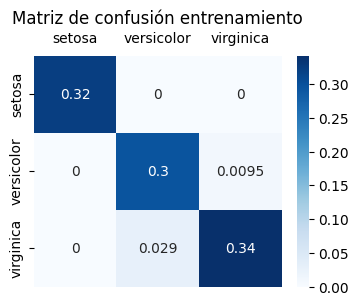

In [17]:
plt.figure(figsize=(4,3), dpi=100)
ax = sns.heatmap(conf/np.sum(conf),
            annot=True, cmap='Blues')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_title("Matriz de confusión entrenamiento")

<div class="alert alert-block alert-info">
  <b>Ejercicio 1:</b><br/>
    Grafica la <b>matriz de confusión</b> para el conjunto de <b>validación</b>.
</div>

In [18]:
# TODO: Agrega las celdas que necesites con tu código

### Entrenamiento

<div class="alert alert-block alert-info">
  <b>Ejercicio 2:</b><br/>
    Utiliza ahora el conjunto de <b>validación</b> para decidir cuál es el mejor valor para el <b>máximo número de hojas</b>.
</div>

In [19]:
# TODO: Agrega las celdas que necesites con tu código

<div class="alert alert-block alert-info">
  <b>Ejercicio 3:</b><br/>
    Utiliza el conjunto de <b>prueba</b> para evaluar el desempeño del valor que elegiste.
</div>

In [20]:
# TODO: Agrega las celdas que necesites con tu código

### Regresión

También es posible utilizar estos árboles para aproximar funciones como un problema de regresión, aunque no suele ser tan eficiente como otras técnicas. [Decision Tree Regression](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py)
<figure>
 <center>
  <img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png" alt="Uso en regresión">
 <figcaption>Ejemplo tomado de la documentaciónd de scikit</figcaption>
 </center>    
</figure>

# Bosques aleatorios

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
forest = RandomForestClassifier(n_estimators=3)

forest.fit(X_train, y_train)
forest_y_pred_idx = forest.predict(X_train)
ac = accuracy_score(y_train, forest_y_pred_idx).round(2)
print("Exactitud al entrenar =", ac)

Exactitud al entrenar = 0.99


<div class="alert alert-block alert-warning">
  Como este conjunto de datos fue hecho a modo, no contamos con ejemplares para validar.
</div>

## Conjunto de datos artificial

Esta función de ```sklearn``` genera muestras simulando bolsas de palabras para diferentes clases de documentos.  Aunque el modelo contiene varias imprecisiones será útil para ilustrar el funcionamiento del algoritmo.

**Documentación:** [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification
)

In [23]:
from sklearn.datasets import make_classification

In [24]:
X1, Y1 = make_classification(
    n_samples = 1000,
    n_features=20, n_classes=5,
    n_redundant=4, n_informative=16, n_clusters_per_class=3
)

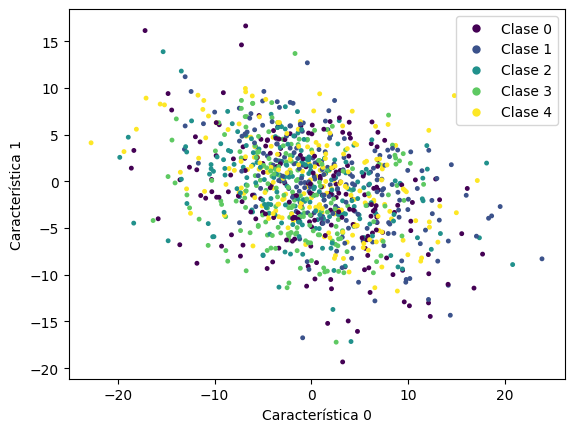

In [26]:
# Eligiendo dos características al azar para visualizar
sc = plt.scatter(X1[:, 0], X1[:, 1], marker=".", c=Y1, s=25)
plt.xlabel('Característica 0')
plt.ylabel('Característica 1')

lp = lambda i: plt.plot([], color=sc.cmap(sc.norm(i)), mec="none",
                        label="Clase {:g}".format(i), ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(Y1)]
v = plt.legend(handles=handles)

## Bosque

In [29]:
# Entrenamiento, validación y prueba
F_X_train, F_X_temp, F_y_train, F_y_temp = train_test_split(X1, Y1, train_size=0.7, random_state=0)
F_X_val, F_X_test, F_y_val, F_y_test = train_test_split(F_X_temp, F_y_temp, train_size=0.6, random_state=0)

In [30]:
# Entrenar un bosque

# Guardarán los datos del último árbol obtenido
art_forest = None
@interact(
    num_árboles = widgets.IntSlider(min=2, max=20, value=5),
    max_profunidad = widgets.IntSlider(min=0, max=20, value=5),
)
def árboles_para_iris(num_árboles, max_profunidad):
    global art_forest
    if max_profunidad == 0:
        max_profunidad = None   # Árboles con hojas puras
    art_forest = RandomForestClassifier(
        n_estimators=num_árboles,
        max_depth=max_profunidad,
    )
    art_forest.fit(F_X_train, F_y_train)
    F_y_pred_idx = art_forest.predict(F_X_train)
    ac = accuracy_score(F_y_train, F_y_pred_idx).round(2)
    print("Exactitud al entrenar =", ac)

    F_y_pred_idx = art_forest.predict(F_X_val)
    ac = accuracy_score(F_y_val, F_y_pred_idx).round(2)
    print("Exactitud al validar =", ac)

interactive(children=(IntSlider(value=5, description='num_árboles', max=20, min=2), IntSlider(value=5, descrip…

In [31]:
F_y_pred_idx = art_forest.predict(F_X_test)
ac = accuracy_score(F_y_test, F_y_pred_idx).round(2)
print("Exactitud al probar =", ac)

Exactitud al probar = 0.46


In [33]:
# Comparando con un solo árbol

art_clf = None
@interact(max_num_hojas = widgets.IntSlider(min=2, max=10, value=3))
def árboles_para_iris(max_num_hojas):
    global art_clf
    art_clf = DecisionTreeClassifier(max_leaf_nodes=max_num_hojas, random_state=0)
    art_clf.fit(F_X_train, F_y_train)
    clf_y_pred_idx = art_clf.predict(F_X_train)
    ac = accuracy_score(F_y_train, clf_y_pred_idx).round(2)
    print("Exactitud al entrenar =", ac)

    clf_y_pred_idx = art_clf.predict(F_X_val)
    ac = accuracy_score(F_y_val, clf_y_pred_idx).round(2)
    print("Exactitud al validar =", ac)

interactive(children=(IntSlider(value=3, description='max_num_hojas', max=10, min=2), Output()), _dom_classes=…

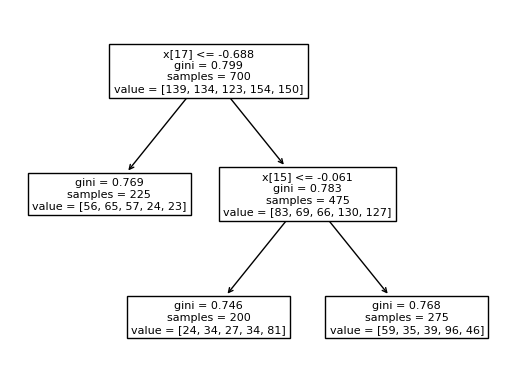

In [34]:
p = tree.plot_tree(art_clf)

## Importancia de las características

La **importancia** de cada característica se calcula como la _media_ y la _desviación estándar_ de la acumulación del decremento de la impureza en cada árbol. [Pixel importances with a parallel forest of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-faces-py)

In [35]:
importances = art_forest.feature_importances_
print("Importancias: ", importances)

orden_importancia = np.argsort(importances)
print("Orden de importancia: ", orden_importancia)

Importancias:  [0.04588731 0.03567181 0.05323559 0.07220446 0.10479713 0.03026095
 0.03475852 0.06661309 0.03083647 0.05984608 0.07066266 0.06583867
 0.04532373 0.00233718 0.05797274 0.03216377 0.03841117 0.10702747
 0.02889473 0.01725647]
Orden de importancia:  [13 19 18  5  8 15  6  1 16 12  0  2 14  9 11  7 10  3  4 17]
